## Import

In [41]:
## import
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn'


## Data Cleaning/ Merging 

In [2]:
## reading in datasets 
df_mask = pd.read_csv('data/mask-use-by-county.csv')
df_votes = pd.read_csv('data/president_county.csv')
df_results = pd.read_csv('data/president_county_candidate.csv')
df_county = pd.read_csv('data/data.csv', encoding = 'ISO-8859-1')

To merge these data sets, we need an index that appoints counties to the county FP (or vice versa).  
Furthermore, df_results needs to be transformed into just Biden and Trump by voting percentage (acheivable by using the total votes in df_votes).

In [3]:
## joining df_mask and df_county on fips code 
df_mask = df_mask.rename(columns= {'COUNTYFP':'fips'})

In [4]:
## cleaning df_county to only useful columns 
df_county = df_county[['fips', 'state_name', 'county_name']]

In [5]:
df_mask = df_mask.merge(df_county, left_on='fips', right_on='fips', suffixes=('_left', '_right'))

In [6]:
## retaining only useful columns 
df_mask = df_mask[['fips', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]

In [7]:
df_results = df_results.merge(df_votes, left_on=['state', 'county'], right_on=['state', 'county'], suffixes=('_left', '_right') )

In [8]:
## try to get fips on df_results 
df_results = df_results.merge(df_county, left_on=['state', 'county'], right_on=['state_name', 'county_name'])

In [9]:
## retaining only useful columns 
df_results = df_results[['fips', 'state', 'county', 'candidate', 'won', 'total_votes_left', 'total_votes_right' ]]



In [10]:
## obtaining voted percentage in the election 
df_results['percentage'] = df_results['total_votes_left'] / df_results['total_votes_right']

In [11]:
## merging results with mask wearing percentage 
df_results = df_results.merge(df_mask, left_on='fips', right_on='fips',suffixes=('_left', '_right') )

In [12]:
## obtaining df_biden and df_trump
df_biden = df_results[df_results['candidate'] == 'Joe Biden']
df_trump = df_results[df_results['candidate'] == 'Donald Trump']

## Analysis 

First, I intend to find if they is a strong correlation between likiness to wear mask and voting for a presidential candidate. I will conduct two linear regressions, one for each of Biden and Trump. The independent variable will be the percentage of people in a county that has a positive response to mask wearing, done so by adding 'Frequently' and 'Always' together.    
  
I choose to do this over using every mask wearing frequency as the independent variable because, obviously, the independent variables would add up to 1.   

The dependent variable is the voting percentage for a certain candidate

### Linear Regression for Biden

In [13]:
## getting column for positive response to wearing mask 
df_trump['positive_mask_wearing'] = df_trump['FREQUENTLY'] + df_trump['ALWAYS']
df_biden['positive_mask_wearing'] = df_biden['FREQUENTLY'] + df_biden['ALWAYS']

In [14]:
df_biden.describe()

,fips,total_votes_left,total_votes_right,percentage,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,positive_mask_wearing
count,3046.000000,3.046000e+03,3.046000e+03,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.00000,3046.000000
mean,30637.943204,2.496245e+04,4.909142e+04,0.334712,0.081112,0.083880,0.122826,0.207667,0.50451,0.712177
std,15034.574989,9.694033e+04,1.499820e+05,0.260949,0.058875,0.055559,0.057711,0.061820,0.15079,0.130671
min,1001.000000,4.000000e+00,6.600000e+01,0.030909,0.000000,0.000000,0.001000,0.029000,0.11500,0.255000
25%,19015.500000,1.261000e+03,5.251250e+03,0.207871,0.034000,0.041000,0.081000,0.165000,0.39200,0.620000
50%,29214.000000,3.562500e+03,1.213750e+04,0.296415,0.070000,0.074000,0.117000,0.205000,0.49500,0.718000
75%,46010.500000,1.122400e+04,3.221725e+04,0.417602,0.116000,0.116000,0.158000,0.247000,0.61000,0.815000
max,56045.000000,3.028885e+06,4.263443e+06,9.532468,0.432000,0.384000,0.422000,0.549000,0.88900,0.992000


In [15]:
## obtain X and Y arrays from dataset 
X_biden = np.array(df_biden['positive_mask_wearing']).reshape(-1, 1)
y_biden = np.array(df_biden['percentage']).reshape(-1, 1)

In [16]:
X_train_biden, X_test_biden, y_train_biden, y_test_biden = train_test_split(
X_biden, y_biden, test_size=0.2, random_state = 1)

In [17]:
regression_biden = linear_model.LinearRegression()

In [18]:
## make regression
regression_biden.fit(X_train_biden, y_train_biden)

##prediction
biden_pred = regression_biden.predict(X_test_biden)

In [19]:
# The coefficients
print('Coefficients: \n', regression_biden.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test_biden, biden_pred))
MSE = mean_squared_error(y_test_biden, biden_pred)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test_biden, biden_pred))

Coefficients: 
 [[0.5639044]]
Mean squared error: 0.02
Coefficient of determination: 0.26


Text(0, 0.5, '% of county voting for biden')

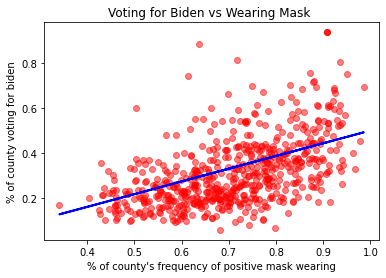

In [20]:
##plotting 
plt.scatter(X_test_biden, y_test_biden, c = 'r', alpha = .5)
plt.plot(X_test_biden, biden_pred, c = 'b', linewidth=2)
plt.title('Voting for Biden vs Wearing Mask ')
plt.xlabel("% of county's frequency of positive mask wearing")
plt.ylabel('% of county voting for biden')

In [21]:
## summary of linear regression 
X = sm.add_constant(X_biden)
est = sm.OLS(y_biden, X)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     274.9
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           3.52e-59
Time:                        19:24:50   Log-Likelihood:                -97.816
No. Observations:                3046   AIC:                             199.6
Df Residuals:                    3044   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0746      0.025     -2.973      0.0

In [22]:
## Cogs109's way of linear regression 
ones = np.ones((3046,1))
A_biden = np.hstack((ones, X_biden))

## solve for the weight vector 
w = np.linalg.lstsq(A_biden, y_biden, rcond=None)[0]

print('Linear model: percentage of voting for biden ={first} + {second} * positive mask wearing'.format(first = w[0], second = w[1]))

Linear model: percentage of voting for biden =[-0.07460831] + [0.57474506] * positive mask wearing


From both sklearn and manual least square calculation, we obtain a coefficient of around 0.56 for positive mask wearing. The y intercept is difficult to interpret intuitively, but it is unattainable because positive mask wearing is generally high enough at 0.71  

Moreover, this answers our research question. We find that the coefficient of the independent variable has a t-value of 16.5, meaning that we are statistically confident that the increase of biden's voting percentage isn't subject to chance. 



### Linear Regression for Trump 

In [23]:
## obtain X and Y arrays from dataset 
X_trump = np.array(df_trump['positive_mask_wearing']).reshape(-1, 1)
y_trump = np.array(df_trump['percentage']).reshape(-1, 1)

## splitting to training and testing datasets 
X_train_trump, X_test_trump, y_train_trump, y_test_trump = train_test_split(
X_trump, y_trump, test_size=0.2, random_state = 1)

In [24]:
regression_trump = linear_model.LinearRegression()

In [25]:
## make regression
regression_trump.fit(X_train_trump, y_train_trump)

##prediction
trump_pred = regression_trump.predict(X_test_trump)

In [26]:
# The coefficients
print('Coefficients: \n', regression_trump.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test_trump, trump_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test_trump, trump_pred))

Coefficients: 
 [[-0.75563936]]
Mean squared error: 0.02
Coefficient of determination: 0.24


Compared to the linear regression for biden, the linear regression for trump seems possess more correlation between mask wearing and voting percentage. The coefficient for positive mask wearing is -.755, meaning that on average, a county that sees more 0.01 increase in positive mask wearing sees a 0.00755 decrease in voting percentage for trump.  

However, the Coefficient of determination for both models seems to be the same. In other words, the voting percentage for both models are affected by positive masking wearing in the same variability. Therefore, I will only use one candidate, hereby choosing biden, going forwards. 


This seems like a fitting model. However, upon reviewing df_biden's summary, I notice a unusual stat with the mean of percetage voted for biden = 0.33. It is strange not only because biden won the election, but he won it with a popular vote of 7 million, about 53%. This is because urban cities are generally more democratic, and small rural areas are generally more republican. Urban cities are also congregated in 1 or 2 counties, thus getting vastly outnumbered by the rural areas. This might create a confounding variable within the model. 

To bypass this, I will use the outcome of the election as the output instead. The dependent variable will be whether the candidate won the election or not, described by 0 or 1. A logistic regression will be used because it is mored suitable for categorical outcomes. 

### Logisitc Regression 

In [27]:
## prepare the dataframe for logistic regression 
df_biden['won'] = df_biden['won'] * 1


In [28]:
## obtaining X and Y labels 
## using all mask wearing variables here to increase the model's predictability 
X_biden = np.array([df_biden['NEVER'], df_biden['RARELY'],df_biden['SOMETIMES'],df_biden['FREQUENTLY'],df_biden['ALWAYS']]).T
y_biden = np.array(df_biden['won']).reshape((-1,))

X_train_biden, X_test_biden, y_train_biden, y_test_biden = train_test_split(
    X_biden, y_biden, test_size=0.2, random_state = 10)


In [29]:
model = LogisticRegression()

In [30]:
## make regression
model.fit(X_train_biden, y_train_biden)

##prediction
biden_pred = model.predict(X_test_biden)

In [31]:
##reporting model 
y_pred = model.predict(X_test_biden)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test_biden, y_test_biden)))



Accuracy of logistic regression classifier on test set: 0.88


In [32]:
## confusion matrix 
cm = confusion_matrix(y_test_biden, y_pred)
cm

array([[521,   8],
       [ 67,  14]])

In [33]:
print(classification_report(y_test_biden, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       529
           1       0.64      0.17      0.27        81

    accuracy                           0.88       610
   macro avg       0.76      0.58      0.60       610
weighted avg       0.85      0.88      0.85       610



As we can see, the accuracy of the logisitic regression is fairly high at 0.88. However, we also see that while the model is very good at predicting counties not voting for biden, it is poor at predicting counties voting for biden. From the confusion matrix, a whopping 588 predictions are nos, outnumbering the predictions for yesses of 22 predictions.   This flaw may have emerged from, again, the disproportionate population in the counties, but to figure that out is beyound the scope of this class.   

The performance of these two models are incomparable. The linear regression offers insight into how much percentage voted for biden changes with more mask wearing, and the logistic regression indicates how might mask wearing change the outcome of a county's election. 

## ML Analysis with KNN 

Now, I intend to train a KNN model to predict whether a county would vote for biden based on its mask wearing tendencies 

In [34]:
## obtaining X and Y labels 
## using all mask wearing variables here to increase the model's predictability 
X_biden = np.array([df_biden['NEVER'], df_biden['RARELY'],df_biden['SOMETIMES'],df_biden['FREQUENTLY'],df_biden['ALWAYS']]).T
y_biden = np.array(df_biden['won']).reshape((-1,))

X_train_biden, X_test_biden, y_train_biden, y_test_biden = train_test_split(
    X_biden, y_biden, test_size=0.2, random_state = 10)


In [36]:
print(X_train_biden.shape)
print(X_test_biden.shape)

(2436, 5)
(610, 5)


In [37]:
print(y_train_biden.shape)
print(y_test_biden.shape)

(2436,)
(610,)


In [48]:
## running k range from 1 to 30 to and measure the accuracies 
k_range = range(1,31)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_biden, y_train_biden)
    y_pred_biden = knn.predict(X_test_biden)
    scores.append(metrics.accuracy_score(y_test_biden, y_pred_biden))

Text(0.5, 0, 'K value')

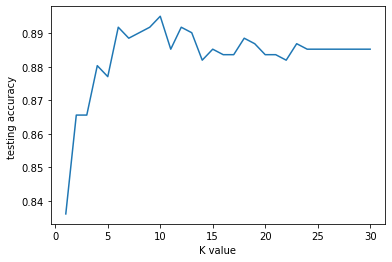

In [53]:
##plotting the test accuracies 
plt.plot(k_range, scores)
plt.ylabel('testing accuracy ')
plt.xlabel('K value')

We find that the optimal value for mask wearing is at k = 10. We set k = 1 and retrain with all the data we have to obtain the final model.

In [55]:
model = KNeighborsClassifier(n_neighbors = 10)
model.fit(X_biden, y_biden)

KNeighborsClassifier(n_neighbors=10)

In [72]:
## creating imaginary data 
county1 = [0.1, 0.0, 0, 0, 0.9]
county2 = [0.2, 0.2, 0.1, 0.1, 0.4]

data = [county1, county2]

##label 
label = {0 : 'voted for trump', 1 :'voted for biden'}

pred = model.predict(data)

print(label[pred[0]])
print(label[pred[1]])


voted for biden
voted for trump
